# A Simple Example of a 3D Warp Simulation of a Thermionic Converter

This notebook follows the "Enhanced_Warp_Thermionic_Converter" example, demonstrating a similar example but operating in 3D. The goal of the notebook is to provide some insights into the different requirements of the 3D simulation for prototyping the 3D extension to the Sirepo interface

8/30/2018

Nathan Cook

## Primary setup differences between 2D and 3D geometry:

1. The solver geometry flag: `w3d.solvergeom = w3d.XYZgeom` for 3D (rather than `XZgeom`)
3. Grid components in the y-coordinate must now be specified:
    - `w3d.ny = NUM_Y`, `w3d.ymmin = Y_MIN`, `w3d.ymmax = Y_MAX`
2. The injection geometry flag: `top.linj_rectangle = (w3d.solvergeom == w3d.XZgeom or w3d.solvergeom == w3d.XYZgeom)` (rather than just `XZgeom`)
3. The cathode area (for normalizing current). This code was already in previous examples:
    - For 2D geometry, `cathode_area = 2.*SOURCE_RADIUS_1*1`
    - For 3D geometry, `cathode_area = 4.*SOURCE_RADIUS_1*SOURCE_RADIUS_2`
4. The fieldsolver specification:
    - `solverE = MultiGrid3D()` or `solverE = MultiGrid3DDielectric()` (currently the Dielectric solver needs some work for parallel execution but should be fine for single processor use)
    
    
## Primary diagnostic differences between 2D and 3D geometry:

1. The potential plot diagnostic shown below needs to be changed to handle the new array dimension in 3D. This is done by grabbing the slice from the center of the y-mesh and slicing using that coordinate:
    - `y_mid = int(NUM_Y/2)` for slicing
    - `plt.imshow(phi_array[xl:xu,y_mid,zl:zu]...)` for plotting
2. The "estimated crossing time" computation has been adjusted for the higher dimensionality. It takes the Ez array (now 3D), and performs a mean across the first axis (x), followed by a second mean across the new first axis (y). The result is an array of length nz corresponding to the average z-field in each plane in the z-coordinate.
    - `flat_Ez = np.mean(np.mean(Ez,0),0)`



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import sys
del sys.argv[1:] #  Necessry to run 'from warp import *' in IPython notebook without conflict.
from warp import * 
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import h5py
from re import findall
from scipy.special import erfinv
from datetime import datetime

import rswarp
from warp.data_dumping.openpmd_diag import ParticleDiagnostic
from rswarp.diagnostics import FieldDiagnostic
from rswarp.utilities.file_utils import cleanupPrevious
from rswarp.utilities.file_utils import readparticles
from rswarp.utilities.file_utils import loadparticlefiles
from rswarp.cathode import sources
from rswarp.cathode import injectors

# Constants imports
from scipy.constants import e, m_e, c, k
kb_eV = 8.6173324e-5 #Bolztmann constant in eV/K
kb_J = k #Boltzmann constant in J/K
m = m_e

# Warp
# Origin date: Mon, 2 Jul 2018 16:00:48 -0600
# Local date: Mon, 2 Jul 2018 16:00:48 -0600
# Commit hash: b464829
# /home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/warp/warp.pyc
# /home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/warp/warpC.so
# Fri Aug 31 16:08:16 2018
# import warp time 0.493509054184 seconds
# For more help, type warphelp()


/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ufuncs import *
/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/scipy/linalg/__init__.py:207: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/scipy/special/_ellip_harm.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ellip_harm_2 import _ellipsoid, _ellipsoid_norm


## Diagnostics

In [3]:
diagDir = 'diags/xzsolver/hdf5/'
field_base_path = 'diags/fields/'
diagFDir = {'magnetic':'diags/fields/magnetic','electric':'diags/fields/electric'}

# Cleanup previous files
cleanupPrevious(diagDir,diagFDir)

## Grid parameters

The grid parameters comprise one of the primary sets of user inputs, and are required for initializing the grid, pre-calculating fundamental currents, and generating the solver. These values are also used throuhgout visualization scripts.

**'Physical' Grid Parameters. These are physically intuitive values for a simple domain specification:**

1. `PLATE_SPACING` - The longitudinal distance (z-axis) between cathode and anode
2. `CHANNEL_WIDTH` - The transverse dimension of the simulation domain


**Technical Grid Parameters. These provide the required inputs for constructing simulation objects, but may be computed from the physical parameters above for a simple rectangular geometry:**

1. `X_MIN, X_MAX` - By default, horizontal domain is `(-0.5*CHANNEL_WIDTH,0.5*CHANNEL_WIDTH)`
2. `X_MIN, X_MAX` - By default, longitudinal domian is `[0, PLATE_SPACING]`
3. `Y_MIN, Y_MAX` - The ignorable plane, but specified for completeness. Defaults to +/- `(-0.5*CHANNEL_WIDTH,0.5*CHANNEL_WIDTH)`
4. `NUM_X` - The number of grid points along x.
5. `NUM_Y` - The number of grid points along y (ignorable for 2DXZ geometry).
6. `NUM_Z` - The number of grid points along z.


In [4]:
#GLOBAL GEOMETRY PARAMETERS FOR USERS
PLATE_SPACING = 10e-6 #plate spacing
CHANNEL_WIDTH = 110e-9 #width of simulation box

#Dimensions
X_MAX = CHANNEL_WIDTH*0.5
X_MIN = -1.*X_MAX
Y_MAX = CHANNEL_WIDTH*0.5
Y_MIN = -1.*Y_MAX
Z_MIN = 0.
Z_MAX = PLATE_SPACING


#Grid parameters
NUM_X = 32
NUM_Y = 32
NUM_Z = 512

#z step size
dz =  (Z_MAX - Z_MIN)/NUM_Z

## Solver Geometry and Boundaries - UPDATED FOR 3D

We now must permit the solver geometry to include 3D Cartesian simulations. This is done by specifying

**`w3d.solvergeom = w3d.XYZgeom`**

hence we no longer need the `assert` statement to limit us to 2D.

In [5]:
#Specify solver geometry
w3d.solvergeom = w3d.XYZgeom

#assert w3d.solvergeom == w3d.XZgeom, \
#        'Solver geometry required to be w3d.XZgeom'

# Set boundary conditions
# Longitudinal conditions overriden by conducting plates
w3d.bound0  = neumann
w3d.boundnz = dirichlet
w3d.boundxy = periodic 
# Particles boundary conditions
top.pbound0  = absorb
top.pboundnz = absorb
top.pboundxy = periodic

# Set grid boundaries
w3d.xmmin = X_MIN
w3d.xmmax = X_MAX
w3d.ymmin = Y_MIN
w3d.ymmax = Y_MAX
w3d.zmmin = 0. 
w3d.zmmax = Z_MAX

# Set grid counts
w3d.nx = NUM_X
w3d.ny = NUM_Y
w3d.nz = NUM_Z

zmesh = np.linspace(0,Z_MAX,NUM_Z+1) #holds the z-axis grid points in an array

## Source parameterization - UPDATED FOR 3D

This section covers source parameterization, in particular how the electrons are emitted from the cathode. Warp permits several options. We want to support three options. For simplicity, I've defined the `USER_INJECT` flag which corresponds to the three possible options:

1. Constant emission - user specifies current. `USER_INJECT = 1`
2. Child-Langmuir emission (computed from geometries) - user selects and current is computed and displayed `USER_INJECT = 2`
3. thermionic emission (computed from cathode temperature) - user selects and current is computed and displayed `USER_INJECT = 3`

**Note that the following USER PARAMETERS are needed for the essential specification of the beam:**

1. Instantiation via species command i.e. `beam = Species(type=Electron, name='beam')`
2. beam radii in x,y via a0, b0 (`beam.a0 = 0.5*BEAM_WIDTH`). In many cases, `BEAM_WIDTH = CHANNEL_WIDTH`.
3. beam current (`beam.ibeam = BEAM_CURRENT`)
4. Cathode temperature in Kelvin (`CATHODE_TEMP`). Should default to 4K.
5. Minimum z-coordinate for injected particles (`Z_PART_MIN`). Must have `Z_PART_MIN > Z_MIN`.


**The next set of parameters are generated from additional user parameters (grid, beam, etc.):**

1. The injection type for the instance of `top` (`top.inejct = 6`). This will be set to 6 (user injection) for most cases, determined by the `USER_INJECT` switch.
2. Number of particles to be injected per step (`top.npinject`). This is computed from grid parameters and defaults to 10 particles per horizontal cell(e.g. `10*NUM_X`).
2. Injection coordinate determination - analytical vs. interpolated (`w3d.l_inj_exact`). Defaults to false for most injection types.
3. Variance of thermal particle velocity distribution in z (`beam.vthz`). Defaults to 0.
4. Variance of thermal particle velocity distribution in transverse plane (`beam.vthperp`). Defaults to 0.


The `rswarp` repository has been updated with a cathode module to streamline the designation of cathode sources via each of these three methods. Below we will demonstrate their use and provide a simple template.

In [6]:
#Cathode and anode settings
CATHODE_TEMP = 1273.15 #1100. #1273.15 #1000. #cathode temperature in K
CATHODE_PHI = 2.0 #work function in eV
ANODE_WF = 0.1
GRID_BIAS = 0.4 #voltage applied to any grid of electrodes

vacuum_level = CATHODE_PHI - ANODE_WF + GRID_BIAS
    
#compute beam cutoff velocity for time-step determinance
beam_beta = sources.compute_cutoff_beta(CATHODE_TEMP)

#Compute Child-Langmuir limit for this setup A/m^2
cl_limit = sources.cl_limit(CATHODE_PHI, ANODE_WF, GRID_BIAS, PLATE_SPACING)

In [7]:
#INJECTION SPECIFICATION
USER_INJECT = 1

# --- Setup simulation species
beam = Species(type=Electron, name='beam')

# --- Set basic beam parameters
SOURCE_RADIUS_1 = 0.5*CHANNEL_WIDTH #a0 parameter - X plane
SOURCE_RADIUS_2 = 0.5*CHANNEL_WIDTH #b0 parameter - Y plane
Z_PART_MIN = dz/8. #starting particle z value


#Compute cathode area for geomtry-specific current calculations
if (w3d.solvergeom == w3d.XYZgeom):
    #For 3D cartesion geometry only
    cathode_area = 4.*SOURCE_RADIUS_1*SOURCE_RADIUS_2
else:
    #Assume 2D XZ geometry
    cathode_area = 2.*SOURCE_RADIUS_1*1. # 1 m is the geometric factor scaling the plane of the ignorable coordinate        
      
#Set a default 'USER_CURRENT' to the Richardson-Dushman current in case of user-specified constant emission
#This will ultimately be an adjustable GUI parameter.
USER_CURRENT = cl_limit*cathode_area #sources.j_rd(CATHODE_TEMP,CATHODE_PHI)*cathode_area 

# If true, position and angle of injected particle are computed analytically rather than interpolated
# Can be false for all but C-L injection (inject=2)
w3d.l_inj_exact = False 

#Specify particles to be injected each step - 10 macro-particles per cell by default, USER SPECIFIED IN FUTURE
PTCL_PER_STEP = 10*NUM_X
top.npinject = PTCL_PER_STEP


# Set the top.linj_rectangle flag so that injection uses the same geometry
top.linj_rectangle = (w3d.solvergeom == w3d.XZgeom or w3d.solvergeom == w3d.XYZgeom)

#Determine an appropriate time step based upon estimated final velocity
vzfinal = sqrt(2.*abs(vacuum_level)*np.abs(beam.charge)/beam.mass)+beam_beta*c
dt = dz/vzfinal #5e-15
top.dt = dt

if vzfinal*top.dt > dz:
    print "Time step dt = {:.3e}s does not constrain motion to a single cell".format(top.dt)    

    
if USER_INJECT == 1:
    # Constant current density - beam transverse velocity fixed to zero, very small longitduinal velocity
    
    #Set injection flag
    top.inject = 1              # 1 means constant; 2 means space-charge limited injection;# 6 means user-specified
    
    top.npinject = PTCL_PER_STEP
    
    beam.ibeam = USER_CURRENT
    beam.a0     = SOURCE_RADIUS_1
    beam.b0     = SOURCE_RADIUS_2
    
    beam.ap0 = .0e0
    beam.bp0 = .0e0

    w3d.l_inj_exact = True
    
    # Specify thermal properties
    beam.vthz = np.sqrt(4. * kb_J / beam.mass)
    beam.vthperp = 0.0
    top.lhalfmaxwellinject = 1  # inject z velocities as half Maxwellian
    
    
elif USER_INJECT == 2:
    CURRENT_MODIFIER = 0.5  # Factor to multiply CL current by when setting beam current
    # Constant current density - beam transverse velocity fixed to zero, very small longitduinal velocity

    # Set injection flag
    top.inject = 1  # 1 means constant; 2 means space-charge limited injection;# 6 means user-specified
    top.npinject = PTCL_PER_STEP
    beam_current = 4. / 9. * eps0 * sqrt(2. * echarge / background_beam.mass) \
                   * ACCEL_VOLTS ** 1.5 / gap_distance ** 2 * cathode_area

    beam.ibeam = beam_current * CURRENT_MODIFIER

    beam.a0 = SOURCE_RADIUS_1
    beam.b0 = SOURCE_RADIUS_1
    beam.ap0 = .0e0
    beam.bp0 = .0e0

    w3d.l_inj_exact = True

    # Initial velocity settings (5% of c)
    vrms = np.sqrt(1 - 1 / (0.05 / 511e3 + 1) ** 2) * 3e8
    top.vzinject = vrms

elif USER_INJECT == 3:
    # True Thermionic injection
    top.inject = 1

    # Set both beams to same npinject to keep weights the same
    beam.npinject = PTCL_PER_STEP

    w3d.l_inj_exact = True

    # Specify thermal properties
    beam.vthz = np.sqrt(EMITTER_TEMP * kb_J / beam.mass)
    beam.vthperp = np.sqrt(EMITTER_TEMP * kb_J / beam.mass)
    top.lhalfmaxwellinject = 1  # inject z velocities as half Maxwellian

    beam_current = sources.j_rd(EMITTER_TEMP, EMITTER_PHI) * cathode_area  # steady state current in Amps
    print('beam current expected: {}, current density {}'.format(beam_current, beam_current / cathode_area))
    jcl = 4. / 9. * eps0 * sqrt(2. * echarge / beam.mass) \
                   * ACCEL_VOLTS ** 1.5 / gap_distance ** 2 * cathode_area
    print('child-langmuir  limit: {}, current density {}'.format(jcl, jcl / cathode_area))
    beam.ibeam = beam_current
    beam.a0 = SOURCE_RADIUS_1
    beam.b0 = SOURCE_RADIUS_1
    beam.ap0 = .0e0
    beam.bp0 = .0e0

derivqty()

## Create solver

In [8]:
# Set up fieldsolver
f3d.mgtol = 1e-6 # Multigrid solver convergence tolerance, in volts. 1 uV is default in Warp.
solverE = MultiGrid3D()
registersolver(solverE)

## Install conductors

In [9]:
# --- Emitter settings
extractor_voltage = vacuum_level
# --- Anode Location
zplate = Z_MAX#1e-6 # --- plate location

# Create source conductors
source = ZPlane(zcent=w3d.zmmin,zsign=-1.,voltage=0.)
installconductor(source, dfill=largepos)

# Create ground plate
plate = ZPlane(voltage=extractor_voltage, zcent=zplate)
installconductor(plate,dfill=largepos)

# Setup the particle scraper
scraper = ParticleScraper([source, plate])

## Define diagnostics

In [10]:
particleperiod = 100
particle_diagnostic_0 = ParticleDiagnostic(period = particleperiod, top = top, w3d = w3d,
                                          species = {species.name: species for species in listofallspecies},
                                          comm_world=comm_world, lparallel_output=False, write_dir = diagDir[:-5])
fieldperiod = 100
efield_diagnostic_0 = FieldDiagnostic.ElectrostaticFields(solver=solverE, top=top, w3d=w3d, comm_world = comm_world,
                                                          period=fieldperiod)

installafterstep(particle_diagnostic_0.write)
installafterstep(efield_diagnostic_0.write)

## Generate simulation package and plot potential

This call has been updated to allow for plotting of the electrostatic potential. Rather than calling generate with its default parameters, the `mgmaxiters` parameter is set to a large value (11000) to allow the initial solve called by generate to produce a potential that has converged to the geometry. After the `generate()` is finished, the parameter is reset to its default of 100.

In [11]:
#prevent GIST from starting upon setup
top.lprntpara = false
top.lpsplots = false

top.verbosity = 0 # Reduce solver verbosity 
solverE.mgverbose = 0 #further reduce output upon stepping - prevents websocket timeouts in Jupyter notebook

#Adjusting the multigrid parameter here improves convergence speed
omega = 2./(1. + np.sin(np.pi/min(NUM_X+1,NUM_Y+1,NUM_Z+1)))
solverE.mgparam = omega

solverE.mgmaxiters = 12000 #rough approximation needed for initial solve to converge
package("w3d")
generate()
solverE.mgmaxiters = 100

 ***  particle simulation package W3D generating
 ---  Resetting lattice array sizes
 ---  Allocating space for particles
 ---  Loading particles
 ---  Setting charge density
 ---  done
 ---  Allocating Win_Moments
 ---  Allocating Z_Moments
 ---  Allocating Lab_Moments
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.689E-05 in 12000 v-cycles             


### UPDATED FOR 3D - Plot the potential

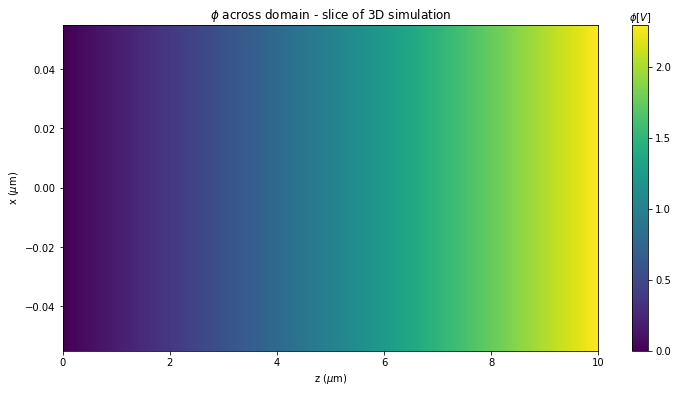

In [19]:
#Need to compute the fields first
phi_array = solverE.getphi()

#print "Maximum epsilon value is {}".format(np.max(epsilon_array))

#Now plot
fig = plt.figure(figsize=(12,6))

X_CELLS = NUM_X
Z_CELLS = NUM_Z

xl = 0
xu = NUM_X
zl = 0 
zu = NUM_Z 

plt.xlabel("z ($\mu$m)")
plt.ylabel("x ($\mu$m)")
plt.title(r"$\phi$ across domain - slice of 3D simulation")

pxmin = ((X_MAX - X_MIN) / X_CELLS * xl + X_MIN) * 1e6
pxmax = ((X_MAX - X_MIN) / X_CELLS * xu + X_MIN) * 1e6
pzmin = (Z_MIN + zl / Z_CELLS * Z_MAX) * 1e6
pzmax = (Z_MAX * zu / Z_CELLS) * 1e6

plt.xlim(pzmin, pzmax)
plt.ylim(pxmin, pxmax)

x_mid = int(NUM_X/2)
y_mid = int(NUM_Y/2)

eps_plt = plt.imshow(phi_array[xl:xu,y_mid,zl:zu],cmap='viridis',extent=[pzmin, pzmax, pxmin, pxmax],aspect='auto')

cbar = fig.colorbar(eps_plt)
cbar.ax.set_xlabel(r"$\phi [V]$")
cbar.ax.xaxis.set_label_position('top')

#plt.savefig('eps_sphere.png',bbox_inches='tight')

### UPDATED FOR 3D: Estimate the time of flight for an electron crossing the gap

**This code has been updated for 3D. It takes the Ez array (now 3D), and performs a mean across the first axis (x), followed by a second mean across the new first axis (y). The result is an array of length nz corresponding to the average z-field in each plane in the z-coordinate**

 - `flat_Ez = np.mean(np.mean(Ez,0),0)`

We will estimate the average time of flight for a particle by averaging over the x-plane of the electric field, then integrating the particle motion in that averaged electric field. For our simulation particle we will take an electron with the expected velocity based on a thermal distribution with the cathode temperature.

*Note that this requires importing the interp1d function from scipy.interpolate*

In [28]:
from scipy.interpolate import interp1d as scipy_interp1d

#Grab Ez from the solver and average over the transverse (x) plane
Ez = solverE.getez()
flat_Ez = np.mean(np.mean(Ez,0),0) #have to flatten the array 2x

#Generate an interpolating function for smooth particle integration
Ez_approx = scipy_interp1d(zmesh,flat_Ez, kind='cubic')

#Integrate the particle motion subject to initial conditions specified by the simulation
tof_expected = sources.compute_expected_time(beam, CATHODE_TEMP, Ez_approx, Z_MIN, Z_MAX, top.dt)

print "Expected time of flight is {}s".format(tof_expected)
print "This corresponds to {} steps".format(tof_expected/top.dt)

Expected time of flight is 2.05831286774e-11s
This corresponds to 1325.0 steps


## Run simulation

In [30]:
#%%time
num_steps = 5000
output_steps = np.linspace(0,num_steps,num_steps/particleperiod + 1)[1:]
step_count = 0
time0 = time.time()
step(num_steps)
time1 = time.time()
time_per_step = (time1-time0)/num_steps

/home/vagrant/.pyenv/versions/2.7.14/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


 ***  particle simulation package W3D running
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.636E-05 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.584E-05 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.533E-05 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.484E-05 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.435E-05 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.387E-05 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.340E-05 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.294E-05 in   100 v-cycles

Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   6.835E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   6.700E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   6.568E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   6.439E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   6.312E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   6.187E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   6.065E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   5.945E-06 in   100 v-cycles             
Multigrid: Maximum number of ite

Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.720E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.684E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.649E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.614E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.580E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.547E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.514E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.482E-06 in   100 v-cycles             
Multigrid: Maximum number of ite

Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.388E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.395E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.401E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.408E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.414E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.420E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.427E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.433E-06 in   100 v-cycles             
Multigrid: Maximum number of ite

Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.834E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.840E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.847E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.854E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.860E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.867E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.874E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.880E-06 in   100 v-cycles             
Multigrid: Maximum number of ite

Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.290E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.296E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.303E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.310E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.316E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.323E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.330E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.337E-06 in   100 v-cycles             
Multigrid: Maximum number of ite

Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.742E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.748E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.755E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.761E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.768E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.774E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.781E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.788E-06 in   100 v-cycles             
Multigrid: Maximum number of ite

Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.174E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.180E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.186E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.193E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.199E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.205E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.211E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.217E-06 in   100 v-cycles             
Multigrid: Maximum number of ite

Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.570E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.575E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.581E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.586E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.592E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.597E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.603E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.608E-06 in   100 v-cycles             
Multigrid: Maximum number of ite

Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.911E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.916E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.920E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.925E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.929E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.934E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.938E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.943E-06 in   100 v-cycles             
Multigrid: Maximum number of ite

Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.180E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.183E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.186E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.190E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.193E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.196E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.199E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.203E-06 in   100 v-cycles             
Multigrid: Maximum number of ite

Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.355E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.357E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.358E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.360E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.362E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.363E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.365E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.367E-06 in   100 v-cycles             
Multigrid: Maximum number of ite

Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.413E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.413E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.412E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.412E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.412E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.412E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.411E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.411E-06 in   100 v-cycles             
Multigrid: Maximum number of ite

Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.326E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.323E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.321E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.318E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.315E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.313E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.310E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.307E-06 in   100 v-cycles             
Multigrid: Maximum number of ite

Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.059E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.054E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.048E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.043E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.037E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.032E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.026E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   4.020E-06 in   100 v-cycles             
Multigrid: Maximum number of ite

Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.570E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.561E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.551E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.542E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.533E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.523E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.514E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   3.505E-06 in   100 v-cycles             
Multigrid: Maximum number of ite

Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.801E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.787E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.773E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.759E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.745E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.731E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.717E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   2.703E-06 in   100 v-cycles             
Multigrid: Maximum number of ite

Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.684E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.665E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.646E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.626E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.607E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.587E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.568E-06 in   100 v-cycles             
Multigrid: Maximum number of iterations reached
Multigrid: Error converged to   1.548E-06 in   100 v-cycles             
Multigrid: Maximum number of ite

## Some basic diagnostics

**The current diagnostic works the same in 2D as in 3D, since it grabs the specific velocity and z-coordinate needed to produce a z-directed current value.**

A few diagnostics for testing. Specifically, we look at the current across the gap at the end of the simulation to verify that it's uniform at the value expected.

In [31]:
efield_path = diagFDir['electric']
efield_files = [os.path.join(efield_path,fn) for fn in os.listdir(efield_path)]
efield_files.sort()

fielddata_file = efield_files[-1]
step_number = int(findall(r'\d+', fielddata_file)[0])
data_efield = h5py.File(fielddata_file, 'r')

Ex = data_efield['data/%s/meshes/E/x' % (step_number)]
Ey = data_efield['data/%s/meshes/E/y' % (step_number)]
Ez = data_efield['data/%s/meshes/E/z' % (step_number)]

phi = data_efield['data/%s/meshes/phi'% (step_number)]

particles_path = diagDir
particles_files = [os.path.join(particles_path,fn) for fn in os.listdir(particles_path)]
particles_files.sort()

particledata_file = particles_files[-1]

# Read single particle diagnostic file in
f0 = readparticles(particledata_file.format(num_steps))
# Read all particles into directory. Structure: name[int stepnumber][str Species name]
fall = loadparticlefiles(particles_path)

In [32]:
def get_zcurrent_new(particle_array, momenta, mesh, particle_weight, dz):
    """
    Find z-directed current on a per cell basis
    particle_array: z positions at a given step
    momenta: particle momenta at a given step in SI units
    mesh: Array of Mesh spacings
    particle_weight: Weight from Warp
    dz: Cell Size
    """    

    charge = 1.60217662e-19
    mass = 9.10938356e-31
    current = np.zeros_like(mesh)
    velocity = c * momenta / np.sqrt(momenta**2 + (mass * c)**2)

    for index, zval in enumerate(particle_array):
        bucket = np.round(zval/dz) #value of the bucket/index in the current array
        current[int(bucket)] += velocity[index]
        
    return current* charge * particle_weight / dz

In [39]:
# Get current for all steps (takes a long time)
current_history = []
for i in range(particleperiod,num_steps,particleperiod):
    #print i
    curr = get_zcurrent_new(fall[i]['beam'][:,4],fall[i]['beam'][:,5],zmesh,beam.sw,dz)
    current_history.append(curr)

current_history = np.asarray(current_history)

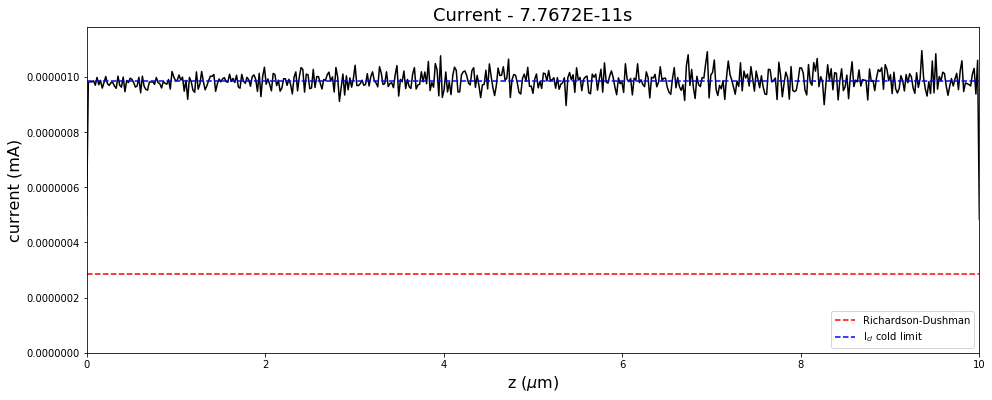

In [40]:
#Plot the current across gap at a single time
fig5 = plt.figure(figsize=(16,6))

#scalings
h_scale = 1.e6
y_range_max = beam.ibeam*1.e3*1.2

#current plotted from grid
plt.plot(zmesh*h_scale,np.array(current_history[-1])*1e3,'k')

#Compute and plot idealized currents as needed
RD_ideal = np.ones(len(zmesh))*sources.j_rd(CATHODE_TEMP,CATHODE_PHI)*cathode_area
JCL_ideal = np.ones(len(zmesh))*cl_limit*cathode_area

if (RD_ideal[0]*1e3 <= y_range_max):
    plt.plot(zmesh*h_scale,RD_ideal*1.e3,'r--',label=r'Richardson-Dushman')

if (JCL_ideal[0]*1e3 <= y_range_max):
    plt.plot(zmesh*h_scale,JCL_ideal*1.e3,'b--',label=r'I$_{cl}$ cold limit')

#labels and legends
plt.xlabel("z ($\mu$m)",fontsize='16')
plt.ylabel("current (mA)",fontsize='16')
plt.title("Current - {:.4E}s".format(fall[num_steps]['time']),fontsize=18)
plt.xlim(Z_MIN,Z_MAX*1.e6)
plt.ylim(0, y_range_max)

plt.legend(loc=4)
title = 'current_{:.4f}ps-test.pdf'.format(CATHODE_TEMP,fall[num_steps]['time']*1.e9)
#fig5.savefig(title,bbox_inches='tight')